In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from datetime import datetime, timedelta

In [43]:
def containmentExpression(df, row): 
    unixTime = pd.Timestamp(0, unit='s')
    startHours = int((row['SubmitTime'] - unixTime).total_seconds()/3600)
    start = pd.to_datetime(startHours, unit='h')
    endHours = int((row['StopTime'] - unixTime).total_seconds()/3600)
    end = pd.to_datetime(endHours, unit='h')

    return (df['Timestamp'] >= start) & (df['Timestamp'] <= end)

def dropContainmentExpression(df, row): 
    unixTime = pd.Timestamp(0, unit='s')
    endHours = int((row['StopTime'] - unixTime).total_seconds()/3600)
    end = pd.to_datetime(endHours, unit='h')
    
    return (end - df['Timestamp'] < timedelta(hours=1)) & (end - df['Timestamp'] >= timedelta(hours=0))

def arrivalContainmentExpression(df, row): 
    unixTime = pd.Timestamp(0, unit='s')
    endHours = int((row['SubmitTime'] - unixTime).total_seconds()/3600)
    end = pd.to_datetime(endHours, unit='h')

    return (end - df['Timestamp'] < timedelta(hours=1)) & (end - df['Timestamp'] >= timedelta(hours=0))


def formCumulativeUsageDataset(path):

    #lambda date parser for year-month-day hour:minute:second
    dateParser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    dataset = pd.read_csv(path, delimiter=',', date_parser=dateParser, parse_dates=['SubmitTime', 'StopTime'])

    unixTime = pd.Timestamp(0, unit='s')

    minTime = dataset['SubmitTime'].min() - unixTime
    minHour = int(minTime.total_seconds()/3600)
    maxTime = dataset['StopTime'].max() - unixTime
    maxHour = int(maxTime.total_seconds()/3600)+1
    
    #create a new dataframe with the cumulative usage
    cumulativeUsage = pd.DataFrame(columns=['Timestamp', 'CPUTime', 'Memory', 'NJobs', 'NProcs', 'ArrivedJobs', 'CompletedJobs'])
    cumulativeUsage['Timestamp'] = np.arange(minHour, maxHour)
    cumulativeUsage = cumulativeUsage.applymap(lambda x: pd.to_datetime(x, unit='h'))
    cumulativeUsage['NJobs'] = 0
    cumulativeUsage['ArrivedJobs'] = 0
    cumulativeUsage['CompletedJobs'] = 0
    cumulativeUsage['CPUTime'] = 0
    cumulativeUsage['Memory'] = 0
    cumulativeUsage['NProcs'] = 0


    #calculate the cumulative usage for the 10 first rows

    for index, row in dataset.iterrows():
        cumulativeUsage.loc[lambda df: containmentExpression(df, row), 'NJobs'] += 1 
        cumulativeUsage.loc[lambda df: arrivalContainmentExpression(df, row), 'ArrivedJobs'] += 1 
        cumulativeUsage.loc[lambda df: dropContainmentExpression(df, row), 'CompletedJobs'] += 1
        try:
            cumulativeUsage.loc[lambda df: containmentExpression(df, row), 'CPUTime'] += row['UsedCPUTime'] if row['UsedCPUTime'] > 0 else 0
        except:
            pass
        try:
            cumulativeUsage.loc[lambda df: containmentExpression(df, row), 'Memory'] += row['UsedMemory'] if row['UsedMemory'] > 0 else 0
        except:
            pass
        cumulativeUsage.loc[lambda df: containmentExpression(df, row), 'NProcs'] += row['NProc'] if row['NProc'] > 0 else 0

    cumulativeUsage.to_csv( f"./datasets/final/final-{path.split('/')[-1]}", index=False)

    return cumulativeUsage


def formDropRateDataset(path):

    #lambda date parser for year-month-day hour:minute:second
    dateParser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    dataset = pd.read_csv(path, delimiter=',', date_parser=dateParser, parse_dates=['SubmitTime', 'StopTime'])

    #create a new column to check if the job has been added to the timesries
    dataset['Check'] = 0

    unixTime = pd.Timestamp(0, unit='s')

    minTime = dataset['SubmitTime'].min() - unixTime
    minHour = int(minTime.total_seconds()/3600)
    maxTime = dataset['StopTime'].max() - unixTime
    maxHour = int(maxTime.total_seconds()/3600)+1
    
    #create a new dataframe with the cumulative usage
    dropRate = pd.DataFrame(columns=['Timestamp', 'DroppedJobs'])
    dropRate['Timestamp'] = np.arange(minHour, maxHour)
    dropRate = dropRate.applymap(lambda x: pd.to_datetime(x, unit='h'))
    dropRate['DroppedJobs'] = 0

    #calculate the cumulative usage for the 10 first rows

    for index, row in dataset.iterrows():
        dropRate.loc[lambda df: dropContainmentExpression(df, row), 'DroppedJobs'] += 1 
    
    dropRate.to_csv( f"./datasets/final/final-{path.split('/')[-1]}", index=False)

    return dropRate


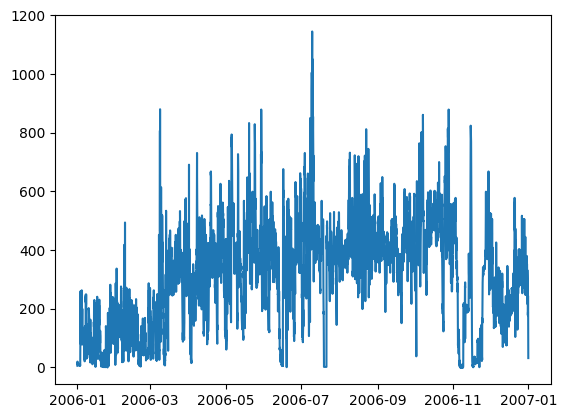

In [ ]:
plt.plot(df['Timestamp'], df['NJobs'])

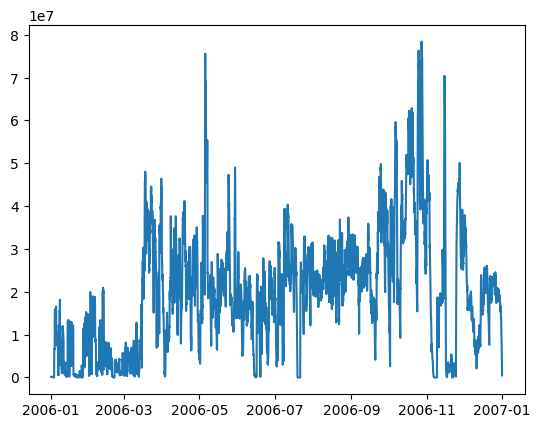

In [27]:
plt.plot(df['Timestamp'], df['CPUTime'])

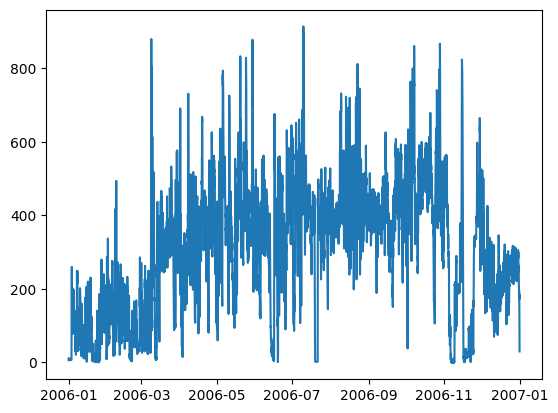

In [28]:
plt.plot(df['Timestamp'], df['NProcs'])

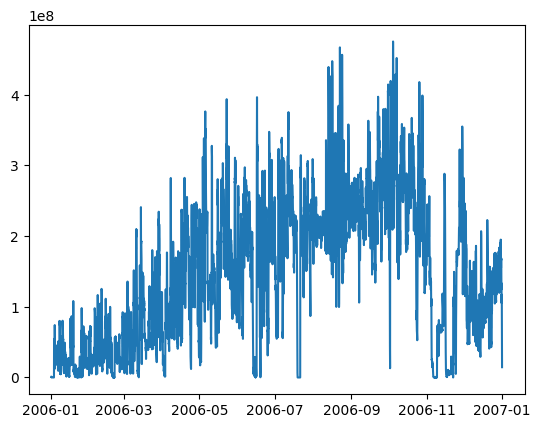

In [29]:
plt.plot(df['Timestamp'], df['Memory'])

In [40]:
df1 = formDropRateDataset('./datasets/dropped/dropped-auvergrid.csv')

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


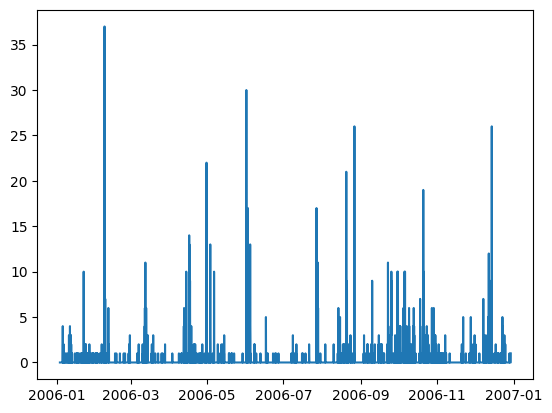

In [41]:
plt.plot(df1['Timestamp'], df1['DroppedJobs'])

### NOTES
- διαφορετικο dataset για ακυρωμενα jobs
- περιοδικοτητα στα time-series (1D) (CPU, Memory, Drop-Rate, Arrival Rate)
- clustering για ReqColumns


In [44]:
formCumulativeUsageDataset('./datasets/formed/formed-auvergrid.csv')
formCumulativeUsageDataset('./datasets/formed/formed-das2.csv')
formCumulativeUsageDataset('./datasets/formed/formed-grid5000.csv')
formCumulativeUsageDataset('./datasets/formed/formed-nordugrid.csv')
formCumulativeUsageDataset('./datasets/formed/formed-sharcnet.csv')

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value enco

,Timestamp,CPUTime,Memory,NJobs,NProcs,ArrivedJobs
0,2005-12-21 03:00:00,0.10,0,1,1,1
1,2005-12-21 04:00:00,0.46,256,5,27,5
2,2005-12-21 05:00:00,0.00,0,0,0,0
3,2005-12-21 06:00:00,0.00,0,0,0,0
4,2005-12-21 07:00:00,0.00,0,0,0,0
...,...,...,...,...,...,...
9380,2007-01-15 23:00:00,27164047.88,43968314,767,1257,74
9381,2007-01-16 00:00:00,26781130.49,35541091,752,1611,183
9382,2007-01-16 01:00:00,24895302.93,17807908,582,1103,257
9383,2007-01-16 02:00:00,14098072.16,8703930,334,863,244


In [45]:
formDropRateDataset('./datasets/dropped/dropped-auvergrid.csv')
formDropRateDataset('./datasets/dropped/dropped-das2.csv')
formDropRateDataset('./datasets/dropped/dropped-grid5000.csv')

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


,Timestamp,DroppedJobs
0,2004-05-04 11:00:00,0
1,2004-05-04 12:00:00,0
2,2004-05-04 13:00:00,0
3,2004-05-04 14:00:00,0
4,2004-05-04 15:00:00,0
...,...,...
22080,2006-11-10 11:00:00,1
22081,2006-11-10 12:00:00,2
22082,2006-11-10 13:00:00,3
22083,2006-11-10 14:00:00,7
